In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
from sklearn.svm import SVC

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from scipy import sparse
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc, accuracy_score
import string 
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dftrain = pd.read_csv('datasources/jigsaw1/train.csv')
dftest = pd.read_csv('datasources/jigsaw1/test.csv')

traincomments = dftrain['comment_text']
testcomments = dftest['comment_text']
wikicomments = pd.concat([traincomments, testcomments])

wikicomments = wikicomments
print('train : {}'.format(traincomments.shape))
print('test  : {}'.format(testcomments.shape))
print('train + test : {}'.format(wikicomments.shape))

train : (159571,)
test  : (153164,)
train + test : (312735,)


In [3]:
dftest['comment_text'].head()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

In [4]:
# remove numeric
#dftrain['comment_text'] = dftrain.comment_text.apply(lambda x: x.translate(str.maketrans('','', string.digits)))
#dftest['comment_text'] = dftest.comment_text.apply(lambda x: x.translate(str.maketrans('','', string.digits)))
# remove punctuation 
#dftrain['comment_text'] = dftrain.comment_text.apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))
#dftest['comment_text'] = dftest.comment_text.apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))

def clean_comments(df):
    comments = []
    for cmt in tqdm(df['comment_text']):
        #suppression des espace et caractères non-alphabetic characters
        comment_text = re.sub("[^a-zA-Z]"," ", cmt)
        comment_text = re.sub(' +', ' ', comment_text.strip())

        comments.append(comment_text)

    return(comments)

#clean comments for both train and test set
dftrain = clean_comments(dftrain)
dftest = clean_comments(dftest)


100%|██████████| 153164/153164 [00:07<00:00, 21071.74it/s]


In [6]:
dftest[0:5]

['Yo bitch Ja Rule is more succesful then you ll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me Ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time',
 'From RfC The title is fine as it is IMO',
 'Sources Zawe Ashton on Lapland',
 'If you have a look back at the source the information I updated was the correct form I can only guess the source hadn t updated I shall update the information once again but thank you for your message',
 'I don t anonymously edit articles at all']

### Analyse par  tfidf: TfidfVectorizer =  CountVectorizer + TfidfTransformer.

In [7]:
vect_word = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [8]:
# Word ngram vector
train_vect = vect_word.fit_transform(dftrain['comment_text'])
test_vect = vect_word.transform(dftest['comment_text'])

TypeError: list indices must be integers or slices, not str

In [13]:
train_vect.shape

(159571, 30000)

In [14]:
print(len(vect_word.get_feature_names()))

30000


In [15]:
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [16]:
# Character n gram vector
tr_vect_char = vect_char.fit_transform(dftrain['comment_text'])
ts_vect_char = vect_char.transform(dftest['comment_text'])

In [17]:
vect_word.get_feature_names()

['aa',
 'aap',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbas',
 'abbey',
 'abbreviated',
 'abbreviation',
 'abbreviations',
 'abc',
 'abc news',
 'abdul',
 'abdullah',
 'abe',
 'abide',
 'abilities',
 'ability',
 'ability create',
 'ability create articles',
 'ability edit',
 'abkhazia',
 'able',
 'able contribute',
 'able edit',
 'able help',
 'able make',
 'able provide',
 'able read',
 'able tell',
 'able understand',
 'able use',
 'abolished',
 'aboriginal',
 'abortion',
 'abortions',
 'abraham',
 'abraham lincoln',
 'abrahamic',
 'abrasive',
 'abroad',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absolutely correct',
 'absolutely reason',
 'absolutely right',
 'absolutely wrong',
 'absolutly',
 'absorbed',
 'abstract',
 'abstracts',
 'absurd',
 'absurdity',
 'abu',
 'abundance',
 'abundant',
 'abundantly',
 'abuse',
 'abuse admin',
 'abuse editing',
 'abuse power',
 'abuse wikipedia',
 'abused',
 'abuser',
 'abuses',
 'abusing',
 'abusing power',
 'abusing power proof

In [18]:
train_vect.shape, tr_vect_char.shape

((159571, 30000), (159571, 40000))

In [19]:
X = sparse.hstack([train_vect, tr_vect_char])

In [26]:
x_test = sparse.hstack([test_vect, ts_vect_char])

In [20]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
#target_col = ['toxic']
y = dftrain[target_col]
y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [48]:
#prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
    #training 
lr = LogisticRegression(C=2,random_state = 42,class_weight = 'balanced')
print('Column:{''}'.format("toxic")) 
lr.fit(X,y["toxic"])
    
# prédiction
pred =  lr.predict(X)

pred_pro = lr.predict_proba(X)[:,1]


Column:toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
pred_test =  lr.predict(x_test)

In [54]:
accuracy_score(y['toxic'],pred)
0.9707778982396551
  9705084257164522

0.9707778982396551

In [ ]:
lr.predict_proba(X)

In [21]:
#prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    #training 
    lr = LogisticRegression(C=2,random_state = 42,class_weight = 'balanced')
    print('Column:{''}'.format(col)) 
    lr.fit(X,y[col])
    pred =  lr.predict(X)
    
        
    # prédiction

    acc_res = accuracy_score(y[col],pred)
    print('\n accuracy_score :{}'.format(acc_res))
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    sns.heatmap(confusion_matrix(y[col],pred), annot=True, fmt='d')
    print('\nclassification_report\n', classification_report(y[col],pred))
"""     
    # ROC
    pred_pro = lr.predict_proba(X)[:,1]
    frp,trp,thres = roc_curve(y[col],pred_pro)
    auc_val =auc(frp,trp)
    plt.figure(figsize=(5,3))
    plt.plot([0,1],[0,1],color='b')
    
    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('ROC : {}'.format(col))"""

Column:toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 accuracy_score :0.9727080735221312

Confusion matrix
 [[139987   4290]
 [    65  15229]]

classification_report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    144277
           1       0.78      1.00      0.87     15294

   micro avg       0.97      0.97      0.97    159571
   macro avg       0.89      0.98      0.93    159571
weighted avg       0.98      0.97      0.97    159571

Column:severe_toxic

 accuracy_score :0.9866015754742403

Confusion matrix
 [[155838   2138]
 [     0   1595]]

classification_report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    157976
           1       0.43      1.00      0.60      1595

   micro avg       0.99      0.99      0.99    159571
   macro avg       0.71      0.99      0.80    159571
weighted avg       0.99      0.99      0.99    159571

Column:obscene

 accuracy_score :0.9870653188862638

Confusion matrix
 [[149060   2062]
 [     2

"     \n    # ROC\n    pred_pro = lr.predict_proba(X)[:,1]\n    frp,trp,thres = roc_curve(y[col],pred_pro)\n    auc_val =auc(frp,trp)\n    plt.figure(figsize=(5,3))\n    plt.plot([0,1],[0,1],color='b')\n    \n    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)\n    plt.legend(loc='lower right')\n    plt.xlabel('True positive rate')\n    plt.ylabel('False positive rate')\n    plt.title('ROC : {}'.format(col))"

In [ ]:
prd

In [ ]:
#del train_vect, test_vect, tr_vect_char, ts_vect_char
#gc.collect()

In [ ]:
for col in target_col:
    print(100 * '=')
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print('\nclassification_report\n', classification_report(y[col],pred))
    

In [ ]:
for col in target_col:    
    pred_pro = lr.predict_proba(X)[:,1]
    frp,trp,thres = roc_curve(y[col],pred_pro)
    auc_val =auc(frp,trp)
    plt.figure(figsize=(5,3))
    plt.plot([0,1],[0,1],color='b')
    
    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('ROC : {}'.format(col))

In [ ]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([dftest['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
#submit.to_csv('toxic_lr.csv',index=False)
submit.head(10)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.3,
                                                   stratify= y,
                                                   random_state=0)

In [29]:
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score

In [30]:
random_state = 40
classifiers = []
classifiers.append(SVC(random_state=random_state))
#classifiers.append(DecisionTreeClassifier(random_state=random_state))
#classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
#classifiers.append(MultinomialNB())

In [31]:

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, 
                                     X_train,
                                     np.ravel(y_train),
                                     scoring='accuracy',
                                     cv=3,
                                     n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [32]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means, 
                       "CrossValErros":cv_std,
                      "Algorithm": [
                                   "Logistic Reg",
                                   "Random Forest",
                                   "Naive Bayes"]})


In [33]:
cv_res

,CrossValMeans,CrossValErros,Algorithm
0,0.959525,0.000628,Logistic Reg
1,0.949838,0.000521,Random Forest
2,0.945371,0.000918,Naive Bayes


Text(0.5, 1.0, 'Cross Val Scores')

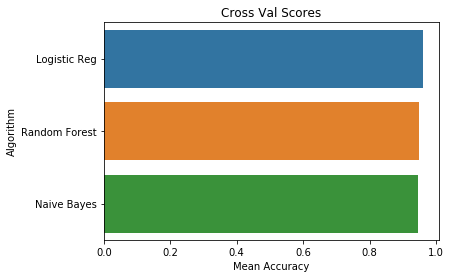

In [34]:
import seaborn as sns
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Val Scores")

In [35]:
cv_res.sort_values("CrossValMeans")

,CrossValMeans,CrossValErros,Algorithm
2,0.945371,0.000918,Naive Bayes
1,0.949838,0.000521,Random Forest
0,0.959525,0.000628,Logistic Reg


In [42]:
votingC = VotingClassifier(estimators=[
    ("LogReg", classifiers[1]),
    ("Naive Bayes", classifiers[2]),
    ("RF", classifiers[0])
], voting = "hard", n_jobs=-1)

In [43]:
votingC.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: WRITEBACKIFCOPY base is read-only

In [ ]:
cross_val_score(votingC,X_train, np.ravel(y_train), scoring="accuracy", cv=10).mean()